In [1]:
!git clone https://github.com/egemenokte/3DLayeredElastic.git
%cd 3DLayeredElastic/Run
import sys
import os
sys.path.append('..')
from Main.MLEV_Parallel import PyMastic
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import random
import sys
import os


Cloning into '3DLayeredElastic'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 134 (delta 23), reused 0 (delta 0), pack-reused 86 (from 1)
Receiving objects: 100% (134/134), 2.97 MiB | 2.94 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/content/3DLayeredElastic/Run


In [3]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.0 MB/s eta 0:00:00


In [4]:
import pickle
import torch
import json
import time
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
import torch
import matplotlib.pyplot as plt
import numpy as np
import logging
import os
import seaborn as sns
import torch.nn as nn
import copy
from torch import nn

from torch.nn import Linear, ReLU,Tanh
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# Read dictionary pkl file
with open('/content/drive/MyDrive/GAT_LET_Analysis/dataset/Frame_data_1000_new_modified.pkl', 'rb') as fp:
    FrameLarge = pickle.load(fp)
with open('/content/drive/MyDrive/GAT_LET_Analysis/dataset/Section_data_1000_new_modified.pkl', 'rb') as fp:
    Section = pickle.load(fp)

In [8]:
Nmaterial=3#maximum number of materials (AC, base, subbase, subgrade)
MaterialType=['AC','B','SG'] #AC, base, subbase, subgrade
Sublayermax=[1,1,1] #each material can have up to 5 sublayers, excluding subgrade

#################May need to change
# Thicknessrange=[[2,20],[4,40],[4,40]] #thickness range in inches
# Modulusrange=[[200,2000],[20,300],[20,300],[5,50]] #modulus range in ksi

Thicknessrange=[[2,20],[4,40]] #thickness range in inches
Modulusrange=[[500,2000],[50,300],[5,50]] #modulus range in ksi
N=1000 #Number of points
zpoints=14 #how many points to generate along z
xpoints=10 #how many points to generate along x
seed=42
############################


Thicknessincrement=[1,2,4]
ModulusIncrement=[50,20,20,5]# increment in modulus sampling
# nurange=[[0,0.499],[0.15,0.499],[0.15,0.499],[0.15,0.499],[0.4,0.499]] #poissons ratio
# nurange=[[0.3,0.4],[0.2,0.499],[0.2,0.499],[0.2,0.499],[0.2,0.499]] #poissons ratio
nurange=[[0.3,0.4],[0.2,0.499],[0.2,0.499]] #poissons ratio
#xmax=40 #40 inches away from the load
#rmax=80 #80 inches away from the load
#LoadRange=[1000,20000] #pounds of force applied
arange=[3,9] #contact radius (in)
arange=[4,4] #contact radius (in)

apoints=2 #how many contact radii to analyze
apoints=1 #how many contact radii to analyze
factor=0.4
filter = 2
split_idx=800
test_idx=900


In [9]:
def generatesection(N,Nmaterial,MaterialType,Sublayermax,Thicknessrange,Modulusrange,
                              zpoints,xpoints,Thicknessincrement,ModulusIncrement,nurange,arange,apoints,seed=42): #generates section based on rules described above
    np.random.seed(seed)
    Section={}
    DataFrame={}
    columns=['Structure','Pressure','ContactRadius','z','r']
    thickCol=[f'H{i}' for i in range(1, sum(Sublayermax))]
    columns.extend(thickCol)
    modCol=[f'E{i}' for i in range(1, sum(Sublayermax)+1)]
    columns.extend(modCol)
    nuCol=[f'nu{i}' for i in range(1, sum(Sublayermax)+1)]
    columns.extend(nuCol)

    for sect in range(N):
        Section[sect]={}
        DataFrame[sect]=np.zeros(len(columns))
        #To generate we have to follow some rules as described above
        #First, decide on number of materials
        MatNum=np.random.randint(2,Nmaterial+1)

        #Then on the thickness
        Thick=[]
        Poisson=[]
        Material=[]
        #for each material, we will have poissons ratio and thickness


        for i in range(MatNum-1):
            T=np.arange(Thicknessrange[i][0],Thicknessrange[i][1]+Thicknessincrement[i],Thicknessincrement[i]) #Increments of 0.5in
            P=np.arange(nurange[i][0],nurange[i][1]+0.001,0.05) #Increments of 0.05
            Thick.append(np.random.choice(T))
            Poisson.append(np.random.choice(P))
            Material.append(MaterialType[i])
        #For subgrade
        P=np.arange(nurange[-1][0],nurange[-1][1]+0.001,0.05)
        Poisson.append(np.random.choice(P))
        Material.append(MaterialType[-1])

        #Round the thickness and poissons ratio
        Thick=np.round(Thick,2)
        Poisson=np.round(Poisson,3)

        #Now we can decide on sublayers
        ThickSub=[]
        MaterialSub=[]
        ModulusSub=[]
        PoissonSub=[]
        for i in range(MatNum-1):
            subs=np.random.randint(1,Sublayermax[i]+1)
            M=np.arange(Modulusrange[i][0],Modulusrange[i][1]+ModulusIncrement[i],ModulusIncrement[i]) #increments of 50ksi
            Modulus0=np.random.choice(M)

            if Thick[i]/subs<1: #if smaller than 1 in, no sublayers
                MaterialSub.append(MaterialType[i])
                ThickSub.append(Thick[i])
                ModulusSub.append(Modulus0)
                PoissonSub.append(Poisson[i])

                continue

            for j in range(subs): #else, divide into sublayers
                MaterialSub.append(MaterialType[i])
                ThickSub.append(Thick[i]/subs)
                PoissonSub.append(Poisson[i])

                if j==0: #if we are at the first sublayer assign modulus 0
                    ModulusSub.append(Modulus0)
                else: #else, assign a smaller modulus
                    Modulus0=np.random.uniform(low=Modulusrange[i][0], high=Modulus0)
                    ModulusSub.append(Modulus0)

        #For subgrade
        ModulusSub.append(np.round(np.random.choice(np.arange(Modulusrange[-1][0],Modulusrange[-1][1]+ModulusIncrement[-1],ModulusIncrement[-1]))))
        PoissonSub.append(Poisson[-1])
        MaterialSub.append('SG')
        #Round the values
        ThickSub=np.round(ThickSub,2)
        ModulusSub=np.round(ModulusSub)
        PoissonSub=np.round(PoissonSub,3)

        #To create the dictionary
        Section[sect]['Material']=Material
        Section[sect]['Thickness']=Thick
        Section[sect]['Poisson']=Poisson
        Section[sect]['MaterialSub']=MaterialSub
        Section[sect]['ThicknessSub']=ThickSub
        Section[sect]['PoissonSub']=PoissonSub
        Section[sect]['ModulusSub']=ModulusSub

        #To create the dataframe
        t=np.append(Section[sect]['ThicknessSub'], np.zeros(sum(Sublayermax)-1-len(Section[sect]['ThicknessSub'])))
        m=np.insert(Section[sect]['ModulusSub'], -1, np.zeros(sum(Sublayermax)-len(Section[sect]['ModulusSub'])))
        p=np.insert(Section[sect]['PoissonSub'], -1, np.zeros(sum(Sublayermax)-len(Section[sect]['PoissonSub'])))
        DataFrame[sect]=np.append(np.zeros(5),t)
        DataFrame[sect][0]=sect+1 #assign structure
        DataFrame[sect][1]=80 #assign pressure of 80 psi (9000/np.pi/6**2)
        DataFrame[sect]=np.append(DataFrame[sect],m)
        DataFrame[sect]=np.append(DataFrame[sect],p)
    Frame=pd.DataFrame.from_dict(DataFrame, orient='index',columns=columns)
    return Section,Frame



In [10]:

Section_temp,Frame=generatesection(N,Nmaterial,MaterialType,Sublayermax,Thicknessrange,Modulusrange,
                          zpoints,xpoints,Thicknessincrement,ModulusIncrement,nurange,arange,apoints,seed=42)

In [11]:
def split_array(array, lengths):

  return np.split(array, np.cumsum(lengths)[:-1])

In [12]:
def generate_query_points(Section, N,xpoints,zpoints,factor,arange,Frame):
    FrameLarge_temp=[]
    final_dict_ztoE=[]
    final_dict_ztoH=[]
    final_dict_ztonu = []
    ZS=[]

    H=[]
    E=[]
    NU = []
    for i in range(N):
        dict_z_to_E = {}
        dict_z_to_H = {}
        dict_z_to_nu={}
        th=sum(Section[i]['Thickness'])+12
        zs=np.power(np.linspace(np.sqrt(0.5),np.power(th,factor),zpoints),1/factor) #sampling near the surface

        zs=np.sort(np.append(zs,np.append(np.cumsum(Section[i]['ThicknessSub'])+0.01,np.cumsum(Section[i]['ThicknessSub'])-0.01)))
        ZS.append(zs)

        E_per_section=np.zeros(len(zs))
        H_per_section = np.zeros(len(zs))
        nu_per_section = np.zeros(len(zs))
        points_above_boundary=np.cumsum(Section[i]['ThicknessSub'])+0.01
        points_below_boundary=np.cumsum(Section[i]['ThicknessSub'])-0.01

        j=0
        while j<=len(Section[i]['ModulusSub'])-1:
            if j==0:
                E_per_section[(zs<=points_below_boundary[j])]=Section[i]['ModulusSub'][j]
                H_per_section[(zs<=points_below_boundary[j])]=Section[i]['ThicknessSub'][j]
                nu_per_section[(zs<=points_below_boundary[j])]=Section[i]['PoissonSub'][j]
                ind=0
                j+=1
            elif j>0 and j<len(Section[i]['ModulusSub'])-1:
                E_per_section[(zs>=points_above_boundary[ind])&(zs<=points_below_boundary[j])]=Section[i]['ModulusSub'][j]
                H_per_section[(zs>=points_above_boundary[ind])&(zs<=points_below_boundary[j])]=Section[i]['ThicknessSub'][j]
                nu_per_section[(zs>=points_above_boundary[ind])&(zs<=points_below_boundary[j])]=Section[i]['PoissonSub'][j]

                ind+=1

                j+=1
            elif j>=len(Section[i]['ModulusSub'])-1:

                E_per_section[(zs>=points_above_boundary[ind])]=Section[i]['ModulusSub'][j]
                H_per_section[(zs>=points_above_boundary[ind])]=-1
                nu_per_section[(zs>=points_above_boundary[ind])]=Section[i]['PoissonSub'][j]
                j+=1

        for z,h in zip(zs,H_per_section):
            dict_z_to_H[z] = h/100
        final_dict_ztoH.append(dict_z_to_H)
        for z,e in zip(zs,E_per_section):
              dict_z_to_E[z]=e/100
        final_dict_ztoE.append(dict_z_to_E)
        for z,nu in zip(zs,nu_per_section):
              dict_z_to_nu[z] = nu
        final_dict_ztonu.append(dict_z_to_nu)


        H.append(H_per_section)
        E.append(E_per_section)
        NU.append(nu_per_section)
        xs = np.linspace(np.sqrt(0.5), np.sqrt(10), xpoints)**2
        #radi=np.sort(random.sample(range(arange[0],arange[1]),apoints))
        radi=[arange[0]]
        Section[i]['z']=zs
        Section[i]['x']=xs
        Section[i]['a']=radi
        FrameTemp=deepcopy(Frame.loc[i:i,:])
        FrameTemp=pd.DataFrame(np.repeat(FrameTemp.values, len(radi)*len(zs)*len(xs), axis=0))
        FrameTemp.columns = Frame.columns
        res = np.matrix([[ii, j, k] for ii in radi
                      for j in zs
                      for k in xs])
        FrameTemp.iloc[:,2:5]=res
        FrameLarge_temp.append(FrameTemp)
    FrameLarge_temp = pd.concat(FrameLarge_temp)
    FrameLarge_temp=FrameLarge_temp.reset_index(drop=True)
    FrameLarge_temp[['Displacement_Z', 'Displacement_H', 'Stress_Z', 'Stress_R', 'Stress_T', 'Stress_RZ', 'Strain_Z', 'Strain_R', 'Strain_T']]=0
    return FrameLarge_temp, ZS, xs, E,NU,final_dict_ztoE,H,final_dict_ztoH,final_dict_ztonu



In [ ]:
len(final_dict_ztoH)

NameError: name 'final_dict_ztoH' is not defined

In [13]:
FrameLarge_temp, ZS, xs, E,NU,final_dict_ztoE,H,final_dict_ztoH,final_dict_ztonu= generate_query_points(Section, N,xpoints,zpoints,factor,arange,Frame)


In [14]:
def remove_strain_z(DF):

    # Remove Structure 94.0 before the loop
    # DF = DF[DF["Structure"] != 94.0]

    ZS_new = []
    Length = DF["Structure"].unique()

    for structure in Length:
        struct = int(structure) - 1
        filtered = DF[DF["Structure"] == structure]

        inp = filtered.loc[:, ["Strain_Z"]] * 1e6

        # Check if any Strain_Z value is greater than 1500
        if (inp['Strain_Z'] >= 1500).any():
            print(f"Removing structure: {structure}")
            DF = DF[DF["Structure"] != structure]
            continue

        z_val = filtered['z'].unique()

        # Normalize z values before appending
        z_val_normalized = z_val / 20
        ZS_new.append(z_val_normalized)

    DF = DF.reset_index(drop=True)
    return ZS_new, DF

In [ ]:
test_length = Length[test_idx:N]
test_length
Length= DF["Structure"].unique()


NameError: name 'Length' is not defined

In [15]:
final_dict_ztoE[909]
import math

In [16]:
def train_val_test_generate( DF,final_dict_ztoE, ZS_new, xs,split_idx, test_idx,N,final_dict_ztoH,final_dict_ztonu):

    print("df")
    print(DF["Structure"].nunique())
    Length= DF["Structure"].unique()


    test_length = Length[test_idx:N]

    ZS_test = ZS_new[test_idx:N]

    TEST=[]
    tolerance = 1e-6

    TEST_out=[]



    for structure in test_length:

        struct = int(structure)-1
        print(struct)
        filtered=DF[DF["Structure"]==structure]

        inp=filtered.loc[:,["z","r"]].copy()

        for idx, col in inp.iterrows():
            z_val = col['z']

            # Find the closest match in the dictionary keys within the tolerance
            matched_key = next((key for key in final_dict_ztoE[struct] if math.isclose(key, z_val, abs_tol=tolerance)), None)

            if matched_key is not None:
                inp.loc[idx, "E"] = final_dict_ztoE[struct][matched_key]
            else:
                print(f"z_val {z_val} not found in final_dict_ztoE for structure {struct}")

            matched_key_H = next((key for key in final_dict_ztoH[struct] if math.isclose(key, z_val, abs_tol=tolerance)), None)
            if matched_key_H is not None:
                inp.loc[idx, "H"] = final_dict_ztoH[struct][matched_key_H]

            matched_key_nu = next((key for key in final_dict_ztonu[struct] if math.isclose(key, z_val, abs_tol=tolerance)), None)
            if matched_key_nu is not None:
                inp.loc[idx, "nu"] = final_dict_ztonu[struct][matched_key_nu]




        total_inputs = inp.values
        TEST.append(total_inputs)
        # print(inputs)

        out = filtered[['Strain_Z','Strain_R','Strain_T']]*1e6

        total_targets=out.values
        TEST_out.append(total_targets)

    TEST_out_com = np.concatenate(TEST_out)
    maxs_test = TEST_out_com.max(axis=0)
    mins_test = TEST_out_com.min(axis=0)

    # TEST_out_scaled = (TEST_out_com-mins_train)/(maxs_train-mins_train)

        # Original lengths of the arrays in TEST_out
    # lengths = [arr.shape[0] for arr in TEST_out]

    # Split the scaled array back into the original list structure
    # TEST_out_scaled = split_array(TEST_out_scaled, lengths)

    return TEST, TEST_out,ZS_test



In [ ]:
test_length

NameError: name 'test_length' is not defined

In [ ]:
FrameLarge[FrameLarge["Structure"]==911]

,Structure,Pressure,ContactRadius,z,r,H1,H2,E1,E2,E3,...,nu3,Displacement_Z,Displacement_H,Stress_Z,Stress_R,Stress_T,Stress_RZ,Strain_Z,Strain_R,Strain_T
154580,911.0,80.0,4.0,0.420448,0.500000,15.0,0.0,1450.0,0.0,35.0,...,0.25,0.001610,-0.000007,105.960747,75.659100,75.766471,2.209206,0.000042,0.000015,0.000015
154581,911.0,80.0,4.0,0.420448,0.960211,15.0,0.0,1450.0,0.0,35.0,...,0.25,0.001600,-0.000014,101.683525,73.157484,73.546803,4.120403,0.000040,0.000014,0.000015
154582,911.0,80.0,4.0,0.420448,1.569258,15.0,0.0,1450.0,0.0,35.0,...,0.25,0.001578,-0.000022,92.351354,67.692826,68.693036,6.291476,0.000035,0.000013,0.000014
154583,911.0,80.0,4.0,0.420448,2.327141,15.0,0.0,1450.0,0.0,35.0,...,0.25,0.001539,-0.000032,76.210506,58.212888,60.255399,8.158953,0.000028,0.000012,0.000014
154584,911.0,80.0,4.0,0.420448,3.233861,15.0,0.0,1450.0,0.0,35.0,...,0.25,0.001483,-0.000042,53.444030,44.743700,48.223091,8.905459,0.000018,0.000010,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154735,911.0,80.0,4.0,27.000000,4.289416,15.0,0.0,1450.0,0.0,35.0,...,0.25,0.001006,0.000022,0.607381,-0.026579,-0.031377,0.051678,0.000018,-0.000005,-0.000005
154736,911.0,80.0,4.0,27.000000,5.493808,15.0,0.0,1450.0,0.0,35.0,...,0.25,0.001002,0.000027,0.599035,-0.023016,-0.030678,0.064881,0.000017,-0.000005,-0.000005
154737,911.0,80.0,4.0,27.000000,6.847036,15.0,0.0,1450.0,0.0,35.0,...,0.25,0.000997,0.000034,0.587680,-0.018260,-0.029727,0.078664,0.000017,-0.000005,-0.000005
154738,911.0,80.0,4.0,27.000000,8.349100,15.0,0.0,1450.0,0.0,35.0,...,0.25,0.000990,0.000040,0.572986,-0.012270,-0.028499,0.092490,0.000017,-0.000004,-0.000005


In [17]:
# train_df = FrameLarge.loc[FrameLarge['Structure']<=split_idx]
# train_df=train_df[['Strain_Z','Strain_R','Strain_T']]


ZS,DF =  remove_strain_z(FrameLarge)
# DF=FrameLarge

TEST, TEST_out,ZS_test=train_val_test_generate( DF,final_dict_ztoE, ZS, xs,split_idx,test_idx,N,final_dict_ztoH,final_dict_ztonu)


Removing structure: 112.0
Removing structure: 216.0
Removing structure: 224.0
Removing structure: 336.0
Removing structure: 353.0
Removing structure: 634.0
Removing structure: 659.0
Removing structure: 664.0
Removing structure: 899.0
Removing structure: 993.0
df
990
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
993
994
995
996
997
998
999


In [18]:
ZS_new=[ele*20 for ele in ZS]

In [ ]:
predicted_values

tensor([[  4.4298,   9.1379,  10.3916],
        [  3.7984,   9.1273,  10.7370],
        [  2.8956,   8.9389,  10.9214],
        ...,
        [ 15.6298, -10.8387, -15.4186],
        [ 16.3168, -11.7908, -16.3903],
        [ 17.1263, -12.9421, -17.5430]])

In [19]:
#Neural network model-> 2 layers
torch.manual_seed(42)
class NeuralNetwork(nn.Module):
    def __init__(self, output_size):
        super(NeuralNetwork, self).__init__()

        # self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        # self.flatten = nn.Flatten()
        self.f1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.f2 = nn.Linear(hidden_size, hidden_size)
        self.f3 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        x = self.f1(x)
        x = self.relu(x)
        x = self.f2(x)
        x = self.relu(x)
        x =  self.f2(x)
        x= self.relu(x)
        x =  self.f2(x)
        x= self.relu(x)
        x = self.f3(x)

        return x

# Define the input size, hidden size, and output size
input_size = 5  # Number of input features
hidden_size =  90 # Number of neurons in the hidden layer
output_size = 3 # Number of output features

# Create the model



In [22]:
path = '/content/drive/MyDrive/GAT_LET_Analysis/pickle/model_epoch_8299.pt'
# path = '/work/pi_eokte_umass_edu/Urja/train_nn/5_layers/0/0/checkpoints/model_epoch_6999.pt'


model = NeuralNetwork(output_size)
state_dict = torch.load(path, map_location='cpu')
model.load_state_dict(state_dict)
# model_state_dict = checkpoint['model_state_dict']
# # print(model_state_dict.keys())
# model.load_state_dict(model_state_dict)
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
        test_inputs = torch.tensor(np.vstack(TEST),dtype=torch.float32)


        test_outputs = model(test_inputs)


In [23]:

with open('/content/drive/MyDrive/GAT_LET_Analysis/training/ZS_test', 'rb') as fp:
    ZS_new = pickle.load(fp)

In [24]:

with open('/content/drive/MyDrive/GAT_LET_Analysis/training/xs', 'rb') as fp:
    xs = pickle.load(fp)

In [34]:
import pickle
with open('/content/drive/MyDrive/GAT_LET_Analysis/evaluation/batched_graph_test.pkl', 'rb') as fp:
    batched_graph_test = pickle.load(fp)

In [25]:

target_test = np.vstack(TEST_out)


predicted_values = test_outputs

In [26]:
predicted_values

tensor([[  4.4298,   9.1379,  10.3916],
        [  3.7984,   9.1273,  10.7370],
        [  2.8956,   8.9389,  10.9214],
        ...,
        [ 15.6298, -10.8387, -15.4186],
        [ 16.3168, -11.7908, -16.3903],
        [ 17.1263, -12.9421, -17.5430]])

In [27]:
# target_test = np.vstack(TEST_out)


mse_z = mean_squared_error( target_test[:, 0], predicted_values[:, 0])
mae_z= mean_absolute_error( target_test[:, 0], predicted_values[:, 0])
mse_r = mean_squared_error( target_test[:, 1], predicted_values[:, 1])
mae_r = mean_absolute_error(target_test[:, 1], predicted_values[:, 1])
mse_t = mean_squared_error( target_test[:, 2], predicted_values[:, 2])
mae_t = mean_absolute_error(target_test[:, 2], predicted_values[:, 2])



print(f'Mean Squared Error (MSE_z): {mse_z:.4f}')
print(f'Mean Squared Error (MSE_r): {mse_r:.4f}')
print(f'Mean Squared Error (MSE_t): {mse_t:.4f}')


print(f'Mean abs Error (MSE_z): {mae_z:.4f}')
print(f'Mean abs Error (MSE_r): {mae_r:.4f}')
print(f'Mean abs Error (MSE_t): {mae_t:.4f}')

Mean Squared Error (MSE_z): 3988.6128
Mean Squared Error (MSE_r): 728.2878
Mean Squared Error (MSE_t): 950.8854
Mean abs Error (MSE_z): 33.8025
Mean abs Error (MSE_r): 16.7118
Mean abs Error (MSE_t): 18.1571


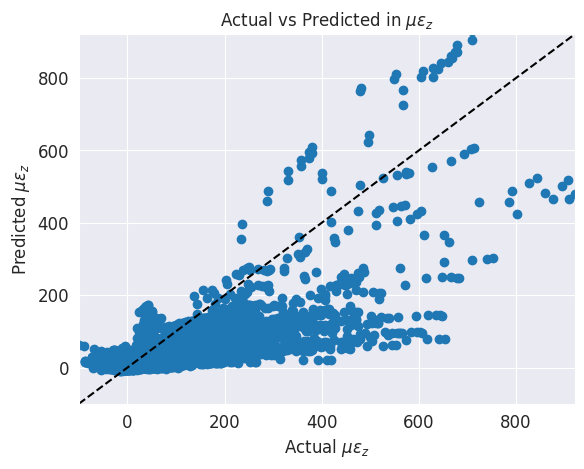

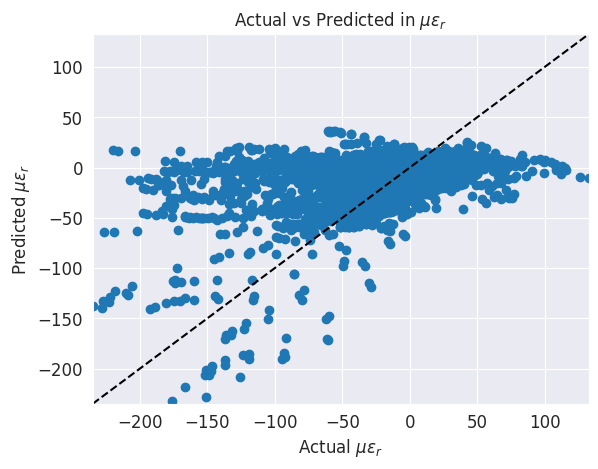

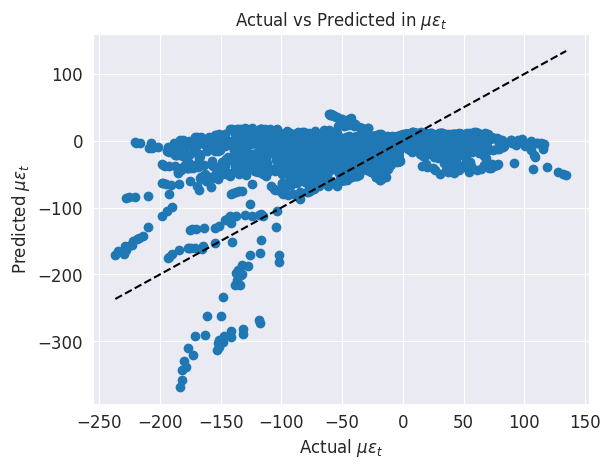

In [28]:

sns.set_style("darkgrid")

stress_z = target_test[:,0]
plt.scatter(stress_z, predicted_values[:,0])
plt.plot([min(stress_z),max(stress_z)],[min(stress_z),max( stress_z)],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_z$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_z$', fontsize=12)
min_val = min(min(stress_z), min(stress_z))
max_val = max(max(stress_z), max(stress_z))

# Set x and y limits to the same range
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.title('Actual vs Predicted in $\mu\epsilon_z$', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()
plt.close()

stress_r = target_test[:,1]
plt.scatter(stress_r, predicted_values[:,1])
plt.plot([min(stress_r),max(stress_r)],[min(stress_r),max( stress_r)],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_r$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_r$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_r$', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
min_val = min(min(stress_r), min(stress_r))
max_val = max(max(stress_r), max(stress_r))

# Set x and y limits to the same range
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.show()
plt.close()

stress_t = target_test[:,2]
plt.scatter(stress_t, predicted_values[:,2])
plt.plot([min(stress_t),max(stress_t)],[min(stress_t),max( stress_t)],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_t$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_t$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_t$', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
min_val = min(min(stress_t), min(stress_t))
max_val = max(max(stress_t), max(stress_t))


In [29]:
xs_converted= xs*2.54
ZS_converted = [i*2.54 for i in ZS_new]

In [30]:
xs=np.round(xs_converted,2)
ZS_new=[np.round(zs,2) for zs in ZS_converted]

In [31]:
xs=np.round(xs,2)
ZS_new=[np.round(zs,2) for zs in ZS_new]

In [32]:
test_struct=0
test_g_struct=0

In [35]:
pred_graph ={}
current_index = 0
for i in range(batched_graph_test.batch_size):
    res_test= len(batched_graph_test[i].y)

    pred_values = predicted_values[current_index:current_index+res_test]

    pred_graph[i]=pred_values
    current_index+=res_test



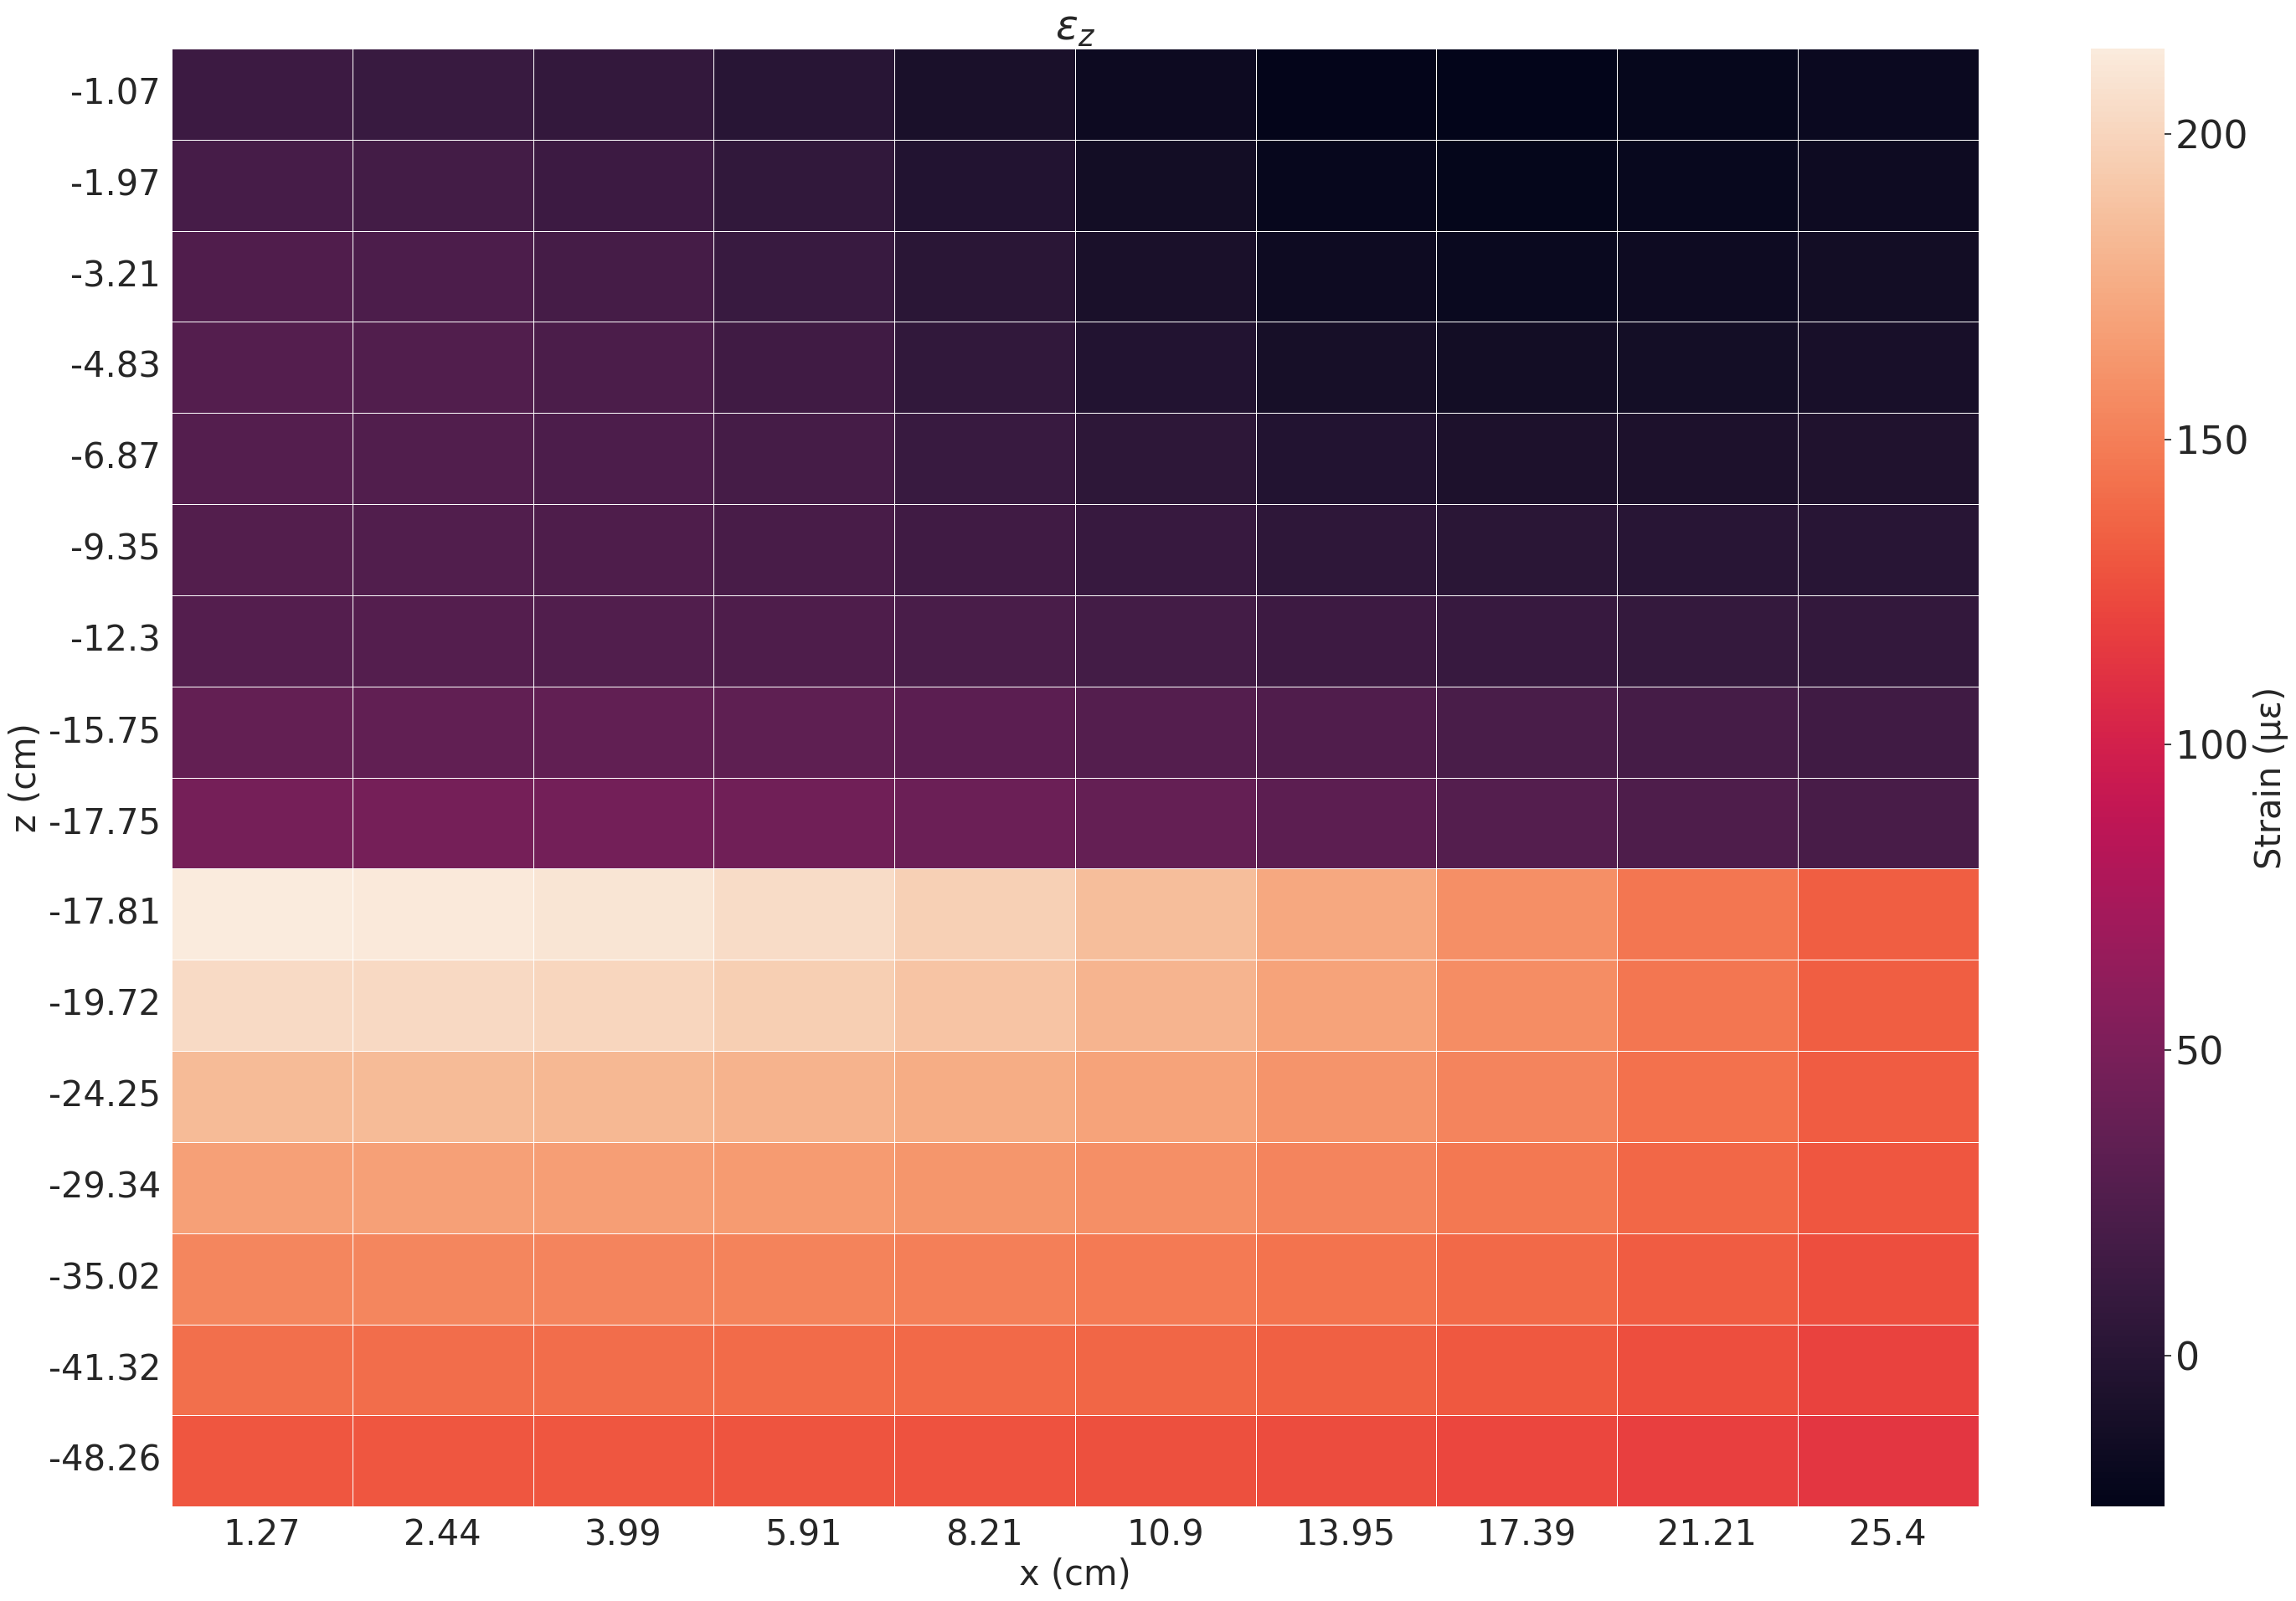

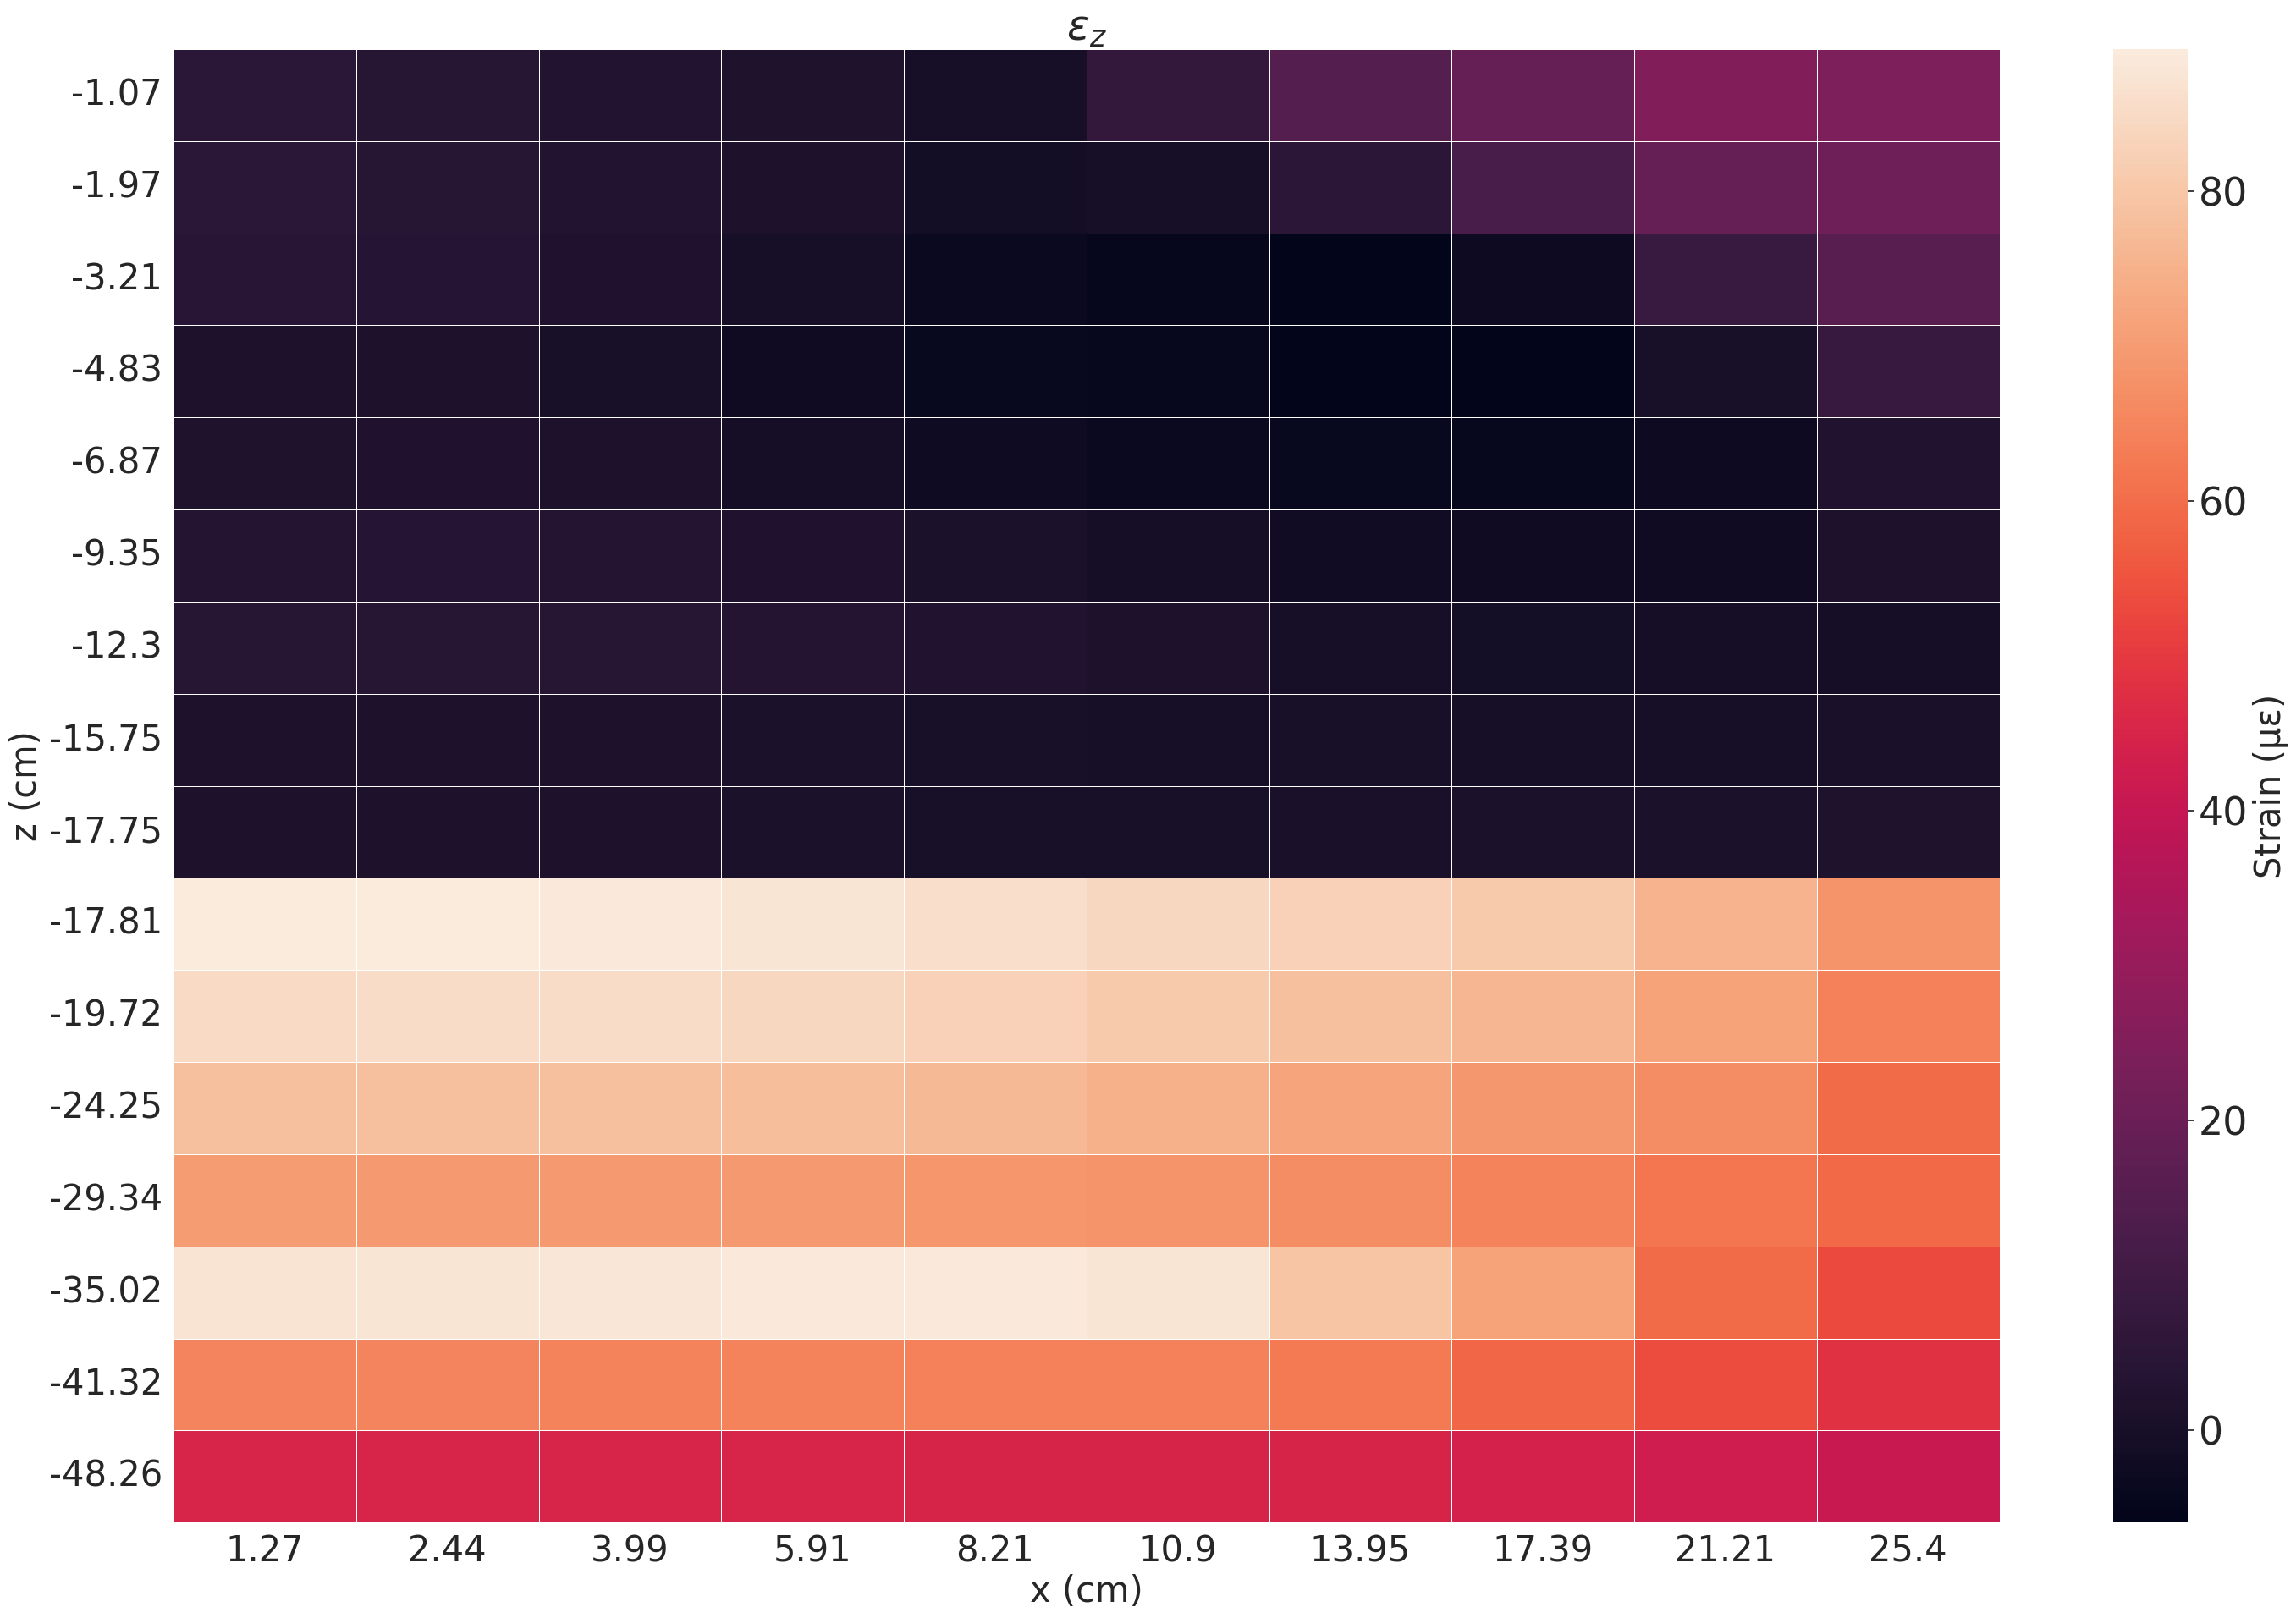

In [40]:
sns.set(rc={'figure.figsize':(30,20)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_prep=np.reshape(batched_graph_test[test_g_struct].y[:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_prep,linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30)
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title('$\epsilon_z$')
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30)
plt.tight_layout()
plt.show()
plt.close()

sns.set(rc={'figure.figsize':(30,20)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_prep=np.reshape(pred_graph[0][:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_prep, linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30)
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title('$\epsilon_z$')
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30)
plt.tight_layout()
plt.show()
plt.close()







